In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

np.random.seed(1234)

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("C:/Users/kimng/Desktop/AI4Good Project/Cleaned data/FullDataset.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 33 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Province/territory_x                          79 non-null     object 
 1   Health region_x                               79 non-null     object 
 2   HR_UID                                        77 non-null     float64
 3   Intensive Care                                79 non-null     int64  
 4   Obstetrics                                    79 non-null     int64  
 5   Pediatrics†                                   79 non-null     int64  
 6   Mental Health 
and Addictions                 79 non-null     int64  
 7   Rehabilitation                                79 non-null     int64  
 8   Long-Term Care                                79 non-null     int64  
 9   Other Acute                                   79 non-null     int64

In [3]:
data['Psychiatrist-to-100,000 population ratio'] = (data['PsychiatristNumber']/data['Population'])*100000
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Province/territory_x                          79 non-null     object 
 1   Health region_x                               79 non-null     object 
 2   HR_UID                                        77 non-null     float64
 3   Intensive Care                                79 non-null     int64  
 4   Obstetrics                                    79 non-null     int64  
 5   Pediatrics†                                   79 non-null     int64  
 6   Mental Health 
and Addictions                 79 non-null     int64  
 7   Rehabilitation                                79 non-null     int64  
 8   Long-Term Care                                79 non-null     int64  
 9   Other Acute                                   79 non-null     int64

In [16]:
#Getting data
X = data[['HR_UID',
          'Health region_x',
          'Province/territory_x',
#          'regular_provider_p',
          'MHBed-to-100,000_LowPerceivedMH' ,
          'Psychiatrist-to-100,000_LowPerceivedMH' ]]
X.dropna(inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 0 to 78
Data columns (total 5 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   HR_UID                                  72 non-null     float64
 1   Health region_x                         72 non-null     object 
 2   Province/territory_x                    72 non-null     object 
 3   MHBed-to-100,000_LowPerceivedMH         72 non-null     float64
 4   Psychiatrist-to-100,000_LowPerceivedMH  72 non-null     float64
dtypes: float64(3), object(2)
memory usage: 3.4+ KB


In [17]:
cluster_dim = [
#               'regular_provider_p', 
               'MHBed-to-100,000_LowPerceivedMH', 
               'Psychiatrist-to-100,000_LowPerceivedMH']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X1 = X[cluster_dim]

X1[cluster_dim] = scaler.fit_transform(X1[cluster_dim])
#X1 = X[cluster_dim]
X1.describe()

,"MHBed-to-100,000_LowPerceivedMH","Psychiatrist-to-100,000_LowPerceivedMH"
count,72.000000,72.000000
mean,0.114269,0.207058
std,0.151454,0.190199
min,0.000000,0.000000
25%,0.037440,0.097010
50%,0.079087,0.143255
75%,0.141166,0.244089
max,1.000000,1.000000


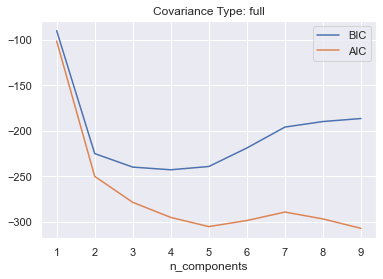

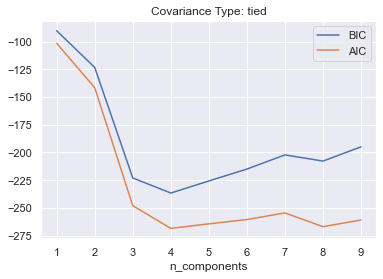

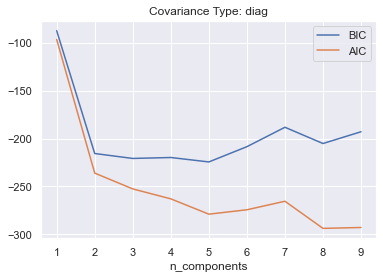

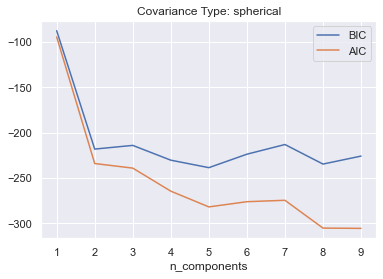

In [18]:
from sklearn import mixture

cov_type = ["full", "tied", "diag", "spherical"]
for c_type in cov_type:
    n_components = np.arange(1, 10)
    clfs = [mixture.GaussianMixture(n, max_iter = 1000, covariance_type = c_type,
                                   random_state = 1234).fit(X1) for n in n_components]
    bics = [clf.bic(X1) for clf in clfs]
    aics = [clf.aic(X1) for clf in clfs]

    plt.plot(n_components, bics, label = 'BIC')
    plt.plot(n_components, aics, label = 'AIC')
    plt.xlabel('n_components')
    plt.legend()
    plt.title('Covariance Type: ' + c_type)
    plt.show()

In [36]:
import plotly.express as px

gmm6 = mixture.GaussianMixture(n_components = 5, max_iter = 1000, 
                               random_state = 1234, covariance_type = 'tied')
gmm6.fit(X1)
labels=gmm6.predict(X1)
X16 = X.copy()

X16['labels'] = labels
X16['labels'] = X16['labels'].apply(str)


fig = px.scatter(X16,
                 y= 'Psychiatrist-to-100,000_LowPerceivedMH', 
                 x= 'MHBed-to-100,000_LowPerceivedMH',
#                 size="regular_provider_p", 
                 color="labels",
                 hover_name="Health region_x",
                 hover_data=['Province/territory_x'],
                 size_max=30)
fig.show()



In [37]:
probs=gmm6.predict_proba(X1)
probs = pd.DataFrame(probs, columns=['prob_groupA', 'prob_groupB', 'prob_groupC', 'prob_groupD', 'prob_groupE',
                                    ])
probs = probs.reset_index()
probs['prob_max'] = probs[['prob_groupA', 'prob_groupB', 'prob_groupC', 'prob_groupD', 'prob_groupE']].max(axis = 1)
probs

,index,prob_groupA,prob_groupB,prob_groupC,prob_groupD,prob_groupE,prob_max
0,0,5.924680e-04,0.980757,1.068318e-53,7.990383e-39,0.018651,0.980757
1,1,9.492810e-08,0.829510,4.711820e-42,6.851836e-52,0.170490,0.829510
2,2,5.843947e-04,0.985258,4.542081e-50,3.009607e-39,0.014158,0.985258
3,3,1.618441e-13,0.023352,2.187565e-63,1.654069e-64,0.976648,0.976648
4,4,4.195151e-10,0.230193,1.187745e-57,1.961405e-56,0.769807,0.769807
...,...,...,...,...,...,...,...
67,67,2.474718e-08,0.591544,1.353570e-52,2.918600e-52,0.408456,0.591544
68,68,5.673521e-06,0.874202,3.316075e-57,1.116460e-44,0.125792,0.874202
69,69,1.014281e-11,0.062867,2.861147e-65,1.585768e-59,0.937133,0.937133
70,70,3.954189e-10,0.163177,1.378006e-64,1.916403e-55,0.836823,0.836823


In [38]:
X16 = X16.reset_index()

In [39]:
X16 = pd.concat([X16, probs],  axis=1)
X16.head()

,index,HR_UID,Health region_x,Province/territory_x,"MHBed-to-100,000_LowPerceivedMH","Psychiatrist-to-100,000_LowPerceivedMH",labels,index,prob_groupA,prob_groupB,prob_groupC,prob_groupD,prob_groupE,prob_max
0,0,4832.0,Calgary Zone,AB,301.0,183.0,1,0,5.924680e-04,0.980757,1.068318e-53,7.990383e-39,0.018651,0.980757
1,1,4833.0,Central Zone,AB,727.0,73.0,1,1,9.492810e-08,0.829510,4.711820e-42,6.851836e-52,0.170490,0.829510
2,2,4834.0,Edmonton Zone,AB,424.0,173.0,1,2,5.843947e-04,0.985258,4.542081e-50,3.009607e-39,0.014158,0.985258
3,3,4835.0,North Zone,AB,89.0,38.0,4,3,1.618441e-13,0.023352,2.187565e-63,1.654069e-64,0.976648,0.976648
4,4,4831.0,South Zone,AB,231.0,76.0,4,4,4.195151e-10,0.230193,1.187745e-57,1.961405e-56,0.769807,0.769807


In [40]:
X16 = X16.round(3)
X16.head()

,index,HR_UID,Health region_x,Province/territory_x,"MHBed-to-100,000_LowPerceivedMH","Psychiatrist-to-100,000_LowPerceivedMH",labels,index,prob_groupA,prob_groupB,prob_groupC,prob_groupD,prob_groupE,prob_max
0,0,4832.0,Calgary Zone,AB,301.0,183.0,1,0,0.001,0.981,0.0,0.0,0.019,0.981
1,1,4833.0,Central Zone,AB,727.0,73.0,1,1,0.000,0.830,0.0,0.0,0.170,0.830
2,2,4834.0,Edmonton Zone,AB,424.0,173.0,1,2,0.001,0.985,0.0,0.0,0.014,0.985
3,3,4835.0,North Zone,AB,89.0,38.0,4,3,0.000,0.023,0.0,0.0,0.977,0.977
4,4,4831.0,South Zone,AB,231.0,76.0,4,4,0.000,0.230,0.0,0.0,0.770,0.770


In [41]:

X16.loc[X16.isnull().any(axis=1)]


,index,HR_UID,Health region_x,Province/territory_x,"MHBed-to-100,000_LowPerceivedMH","Psychiatrist-to-100,000_LowPerceivedMH",labels,index,prob_groupA,prob_groupB,prob_groupC,prob_groupD,prob_groupE,prob_max


In [42]:
X16.to_csv('GMM_MentalHealthcare_labels.csv')